In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

/home/habrami/anaconda3/envs/ml/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    download=True
)

In [3]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
                        
    'test': DataLoader(test_data,
                       batch_size=100,
                       shuffle=True,
                       num_workers=1)
}

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x)

In [5]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [6]:
from torchsummary import summary

summary(Net(), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


/tmp/ipykernel_40867/1003669837.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


In [7]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data) / len(loaders['train'].dataset)} ({100. * batch_idx / len(loaders['train']):.0f}%)]\t{loss.item():.6f}")

def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item() 

    test_loss /= len(loaders['test'].dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%\n)")


In [8]:
for epoch in range(1, 11):
    train(epoch)
    test()

/tmp/ipykernel_40867/1003669837.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0.0 (0%)]	2.304188
Train Epoch: 1 [0.03333333333333333 (3%)]	2.294559
Train Epoch: 1 [0.06666666666666667 (7%)]	2.230612
Train Epoch: 1 [0.1 (10%)]	1.992355
Train Epoch: 1 [0.13333333333333333 (13%)]	1.874871
Train Epoch: 1 [0.16666666666666666 (17%)]	1.852045
Train Epoch: 1 [0.2 (20%)]	1.739153
Train Epoch: 1 [0.23333333333333334 (23%)]	1.668005
Train Epoch: 1 [0.26666666666666666 (27%)]	1.731618
Train Epoch: 1 [0.3 (30%)]	1.746990
Train Epoch: 1 [0.3333333333333333 (33%)]	1.711877
Train Epoch: 1 [0.36666666666666664 (37%)]	1.675116
Train Epoch: 1 [0.4 (40%)]	1.722205
Train Epoch: 1 [0.43333333333333335 (43%)]	1.662005
Train Epoch: 1 [0.4666666666666667 (47%)]	1.639886
Train Epoch: 1 [0.5 (50%)]	1.630404
Train Epoch: 1 [0.5333333333333333 (53%)]	1.640500
Train Epoch: 1 [0.5666666666666667 (57%)]	1.610165
Train Epoch: 1 [0.6 (60%)]	1.570382
Train Epoch: 1 [0.6333333333333333 (63%)]	1.635677
Train Epoch: 1 [0.6666666666666666 (67%)]	1.649343
Train Epoch: 1 [0.7 (70%)]	1.

/tmp/ipykernel_40867/1003669837.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Prediction: 7


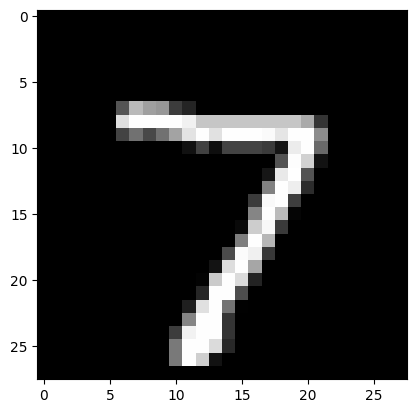

In [23]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[0]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()

In [12]:
FILE = "mnist_model.pth"
torch.save(model.state_dict(), FILE)

In [20]:
import numpy as np

example_data = test_data[5][0].numpy()
np.save('test_data.npy', example_data)